In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import rdkit
from rdkit import DataStructs
import rdkit.Chem.AllChem as Chem

import olympus
from olympus.datasets import Dataset
from olympus.emulators import Emulator
from olympus.campaigns import Campaign 
from olympus.scalarizers import Scalarizer
from olympus.plotter import Plotter

from olympus.utils.misc import get_hypervolume, get_pareto, get_pareto_set


In [4]:
# helper functions


def get_single_traces(campaigns):
    traces = []
    for campaign in campaigns:
        trace = campaign.best_values
        assert trace.shape[1]==1
        traces.append(trace)
    return np.array(traces).squeeze(axis=-1)
    

def get_traces(campaigns, scalarizer):
    traces = []
    for campaign in campaigns:
#         print(campaign.observations.get_values().shape)
        values = campaign.observations.get_values()
        scalarized = scalarizer.scalarize(values)
        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        #instance_trace = []
        trace0 = values[trace_best_idx, 0]
        trace1 = values[trace_best_idx, 1]
        trace2 = values[trace_best_idx, 2]
        traces.append([trace0, trace1, trace2])
    return np.array(traces)


def get_frac_top_k(campaigns, dataset, scalarizer, k):
    ''' returns the fraction of tolerable candidates measuremd at each iteration
    '''
    traces = []
    
    values = dataset.targets.values
    scalarized = scalarizer.scalarize(values)
    sort_idxs = np.argsort(scalarized, axis=0)
    sort_values = [values[i] for i in sort_idxs]
    
    for campaign in campaigns:
        campaign_trace = []
        campaign_values = campaign.observations.get_values()
        for val_ix in range(len(campaign_values)):
            campaign_trace.append(
                sum(val in campaign_values[:val_ix] for val in sort_values)/ len(sort_values)
            )
        traces.append(campaign_trace)
        
    return np.array(traces)
    


def plot_trace_mean(traces, obj_num=0, ax=None, color=None, label=None, use_std_err=True):

    if obj_num==None:
        pass
    elif isinstance(obj_num, int):
        traces = traces[:, obj_num, :]
        
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    ax.plot(x, mean, color='#444444', linewidth=5, zorder=11)
    ax.plot(x, mean, color=color, linewidth=4, label=label, zorder=11)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color, zorder=10)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)


def plot_trace_sigle(pkl_file, ax, obj_name, goal='min', color='k', label='', shift=0.0, use_std_err=True):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    plot_trace_mean(data, obj_name, goal=goal, ax=ax, color=color, label=label, shift=shift, use_std_err=use_std_err)
    

def gradient_patch(ax, xmin, xmax, ymin, ymax, fill_color='k', alpha=1, zorder=1):
    
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    
    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Rectangle(xy=(xmin, ymin), width=xmax-xmin, height=ymax-ymin, 
                          facecolor='none', edgecolor='none')
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

## Case study 1 - compre performance metrics

dye_lasers, redoxmers

### Plots to make

* multi-objective traces (make general purpose function)

* fraction of tolerable candidates found

In [ ]:
#------------
# DYE LASERS
#------------
case_study = 'case_study_1'
dataset = 'dye_lasers'

# load results

with open(f'{case_study}/RandomSearch/{dataset}/results.pkl', 'rb') as content:
    data_random = pickle.load(content)
    
# with open(f'{case_study}/Genetic/{dataset}/results.pkl', 'rb') as content:
#     data_genetic = pickle.load(content)
    
# with open(f'{case_study}/Hyperopt/{dataset}/results.pkl', 'rb') as content:
#     data_hyperopt = pickle.load(content)
    
with open(f'{case_study}/Gpyopt/{dataset}/results.pkl', 'rb') as content:
    data_gpyopt = pickle.load(content)
    
# with open(f'{case_study}/Gryffin/{dataset}/results.pkl', 'rb') as content:
#     data_gryffin = pickle.load(content)

with open(f'{case_study}/Dragonfly/{dataset}/results.pkl', 'rb') as content:
    data_dragonfly = pickle.load(content)
    
with open(f'{case_study}/Botorch/{dataset}/results.pkl', 'rb') as content:
    data_botorch = pickle.load(content)
    
# with open(f'{case_study}/Smac/{dataset}/results.pkl', 'rb') as content:
#     data_smac = pickle.load(content)
    
with open(f'{case_study}/Hebo/{dataset}/results.pkl', 'rb') as content:
    data_hebo = pickle.load(content)
    
    
print('NUM RANDOM :', len(data_random))
#print('NUM GENETIC :', len(data_genetic))
#print('NUM HYPEROPT :', len(data_hyperopt))
print('NUM GPYOPT :', len(data_gpyopt))
#print('NUM GRYFFIN :', len(data_gryffin))
print('NUM DRAGONFLY :', len(data_dragonfly))
print('NUM BOTORCH :', len(data_botorch))
print('NUM HEBO :', len(data_hebo))

In [ ]:
scalarizer = Scalarizer(
        kind='Chimera', 
        value_space=Dataset(kind='dye_lasers').value_space,
        goals=['max', 'min', 'max'],
        tolerances=[0.7, 0.2, 0.2],
        absolutes=[True, True, True]
    )

traces_random = get_traces(data_random, scalarizer)
#traces_genetic = get_traces(data_genetic, scalarizer)
#traces_hyperopt = get_traces(data_hyperopt, scalarizer)
traces_gpyopt = get_traces(data_gpyopt, scalarizer)
#traces_gryffin = get_traces(data_gryffin, scalarizer)
traces_dragonfly = get_traces(data_dragonfly, scalarizer)
traces_botorch = get_traces(data_botorch, scalarizer)
traces_hebo = get_traces(data_hebo, scalarizer)

In [ ]:
# MOO trace plot

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13,4), sharex=True)

axes[0].set_title('First objective')
axes[1].set_title('Second objective')
axes[2].set_title('Third objective')

for i in range(3):
    plot_trace_mean(traces_random, obj_num=i, ax=axes[i], color='gray', label='Random')
    plot_trace_mean(traces_gpyopt, obj_num=i, ax=axes[i], color='g', label='GPyOpt')
    plot_trace_mean(traces_dragonfly, obj_num=i, ax=axes[i], color='#dd882c', label='Dragonfly')
    plot_trace_mean(traces_botorch, obj_num=i, ax=axes[i], color='#4267B2', label='Botorch')
    plot_trace_mean(traces_hebo, obj_num=i, ax=axes[i], color='#ffb703', label='Hebo')
    
    
axes[0].set_xlim(0., 200.)
axes[0].set_ylim(0.6, 0.88)
axes[0].fill_between(x=[0, 200], y1=scalarizer.tolerances[0], y2=0., alpha=0.2, color='gray')
axes[0].axhline(y=scalarizer.tolerances[0], linestyle='--', linewidth=2, color='k', zorder=2)
axes[0].legend(loc='lower right', ncol=2, fontsize=12)
axes[0].set_xlabel('# evaluations', fontsize=12)
axes[0].set_ylabel('peak score [a.u.]', fontsize=12)

axes[1].set_xlim(0., 200.)
axes[1].set_ylim(0.050, 0.25)
axes[1].fill_between(x=[0, 200], y1=scalarizer.tolerances[1], y2=0.25, alpha=0.2, color='gray')
axes[1].axhline(y=scalarizer.tolerances[1], linestyle='--', linewidth=2, color='k', zorder=2)
axes[1].set_ylabel('spectral overlap [a.u.]', fontsize=12)

axes[1].set_xlabel('# evaluations', fontsize=12)

axes[2].set_xlim(0., 200.)
axes[2].set_xlabel('# evaluations', fontsize=12)
axes[2].set_ylabel('fluorescence rate [ns$^{-1}$]', fontsize=12)



plt.tight_layout()
plt.savefig('cs1_dye_lasers_traces.png', dpi=300)

In [ ]:
dataset = Dataset(kind='dye_lasers')
dataset.target_names

In [ ]:
top_k_traces_random = get_frac_top_k(data_random, dataset, scalarizer, 20)

## Case study 2 (Suzuki)

## Case study 2 (buchwald)

see if trends carry between related datasets

### Plots to make 

* traces
* regret after x iterations
* best candidate rank after x

In [3]:
case_study = 'case_study_2_buchwald'

# load results

data_random = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    with open(f'{case_study}/RandomSearch/buchwald_{sub}/results.pkl', 'rb') as content:
        data_random_ = pickle.load(content)
        data_random[sub] = data_random_
        
data_gpyopt = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    with open(f'{case_study}/Gpyopt/buchwald_{sub}/results.pkl', 'rb') as content:
        data_gpyopt_ = pickle.load(content)
        data_gpyopt[sub] = data_gpyopt_
        
# data_dragonfly = {}
# for sub in ['a', 'b', 'c', 'd', 'e']:
#     with open(f'{case_study}/Dragonfly/buchwald_{sub}/results.pkl', 'rb') as content:
#         data_dragonfly_ = pickle.load(content)
#         data_dragonfly[sub] = data_dragonfly_
        
data_botorch = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    with open(f'{case_study}/Botorch/buchwald_{sub}/results.pkl', 'rb') as content:
        data_botorch_ = pickle.load(content)
        data_botorch[sub] = data_botorch_
        
data_gryffin = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    with open(f'{case_study}/Gryffin/buchwald_{sub}/results.pkl', 'rb') as content:
        data_gryffin_ = pickle.load(content)
        data_gryffin[sub] = data_gryffin_
        
        
# data_hebo = {}
# for sub in ['a', 'b', 'c', 'd', 'e']:
#     with open(f'{case_study}/Hebo/buchwald_{sub}/results.pkl', 'rb') as content:
#         data_hebo_ = pickle.load(content)
#         data_hebo[sub] = data_hebo_
        
    
# print('NUM RANDOM :', len(data_random))
# #print('NUM GENETIC :', len(data_genetic))
# #print('NUM HYPEROPT :', len(data_hyperopt))
# print('NUM GPYOPT :', len(data_gpyopt))
# #print('NUM GRYFFIN :', len(data_gryffin))
# print('NUM DRAGONFLY :', len(data_dragonfly))
# print('NUM BOTORCH :', len(data_botorch))
# print('NUM HEBO :', len(data_hebo))

In [4]:
# get traces
traces_random = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    traces_random[sub]= get_single_traces(data_random[sub])
    
traces_gpyopt = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    traces_gpyopt[sub]= get_single_traces(data_gpyopt[sub])
    
# traces_dragonfly = {}
# for sub in ['a', 'b', 'c', 'd', 'e']:
#     traces_dragonfly[sub]= get_single_traces(data_dragonfly[sub])
    
traces_botorch = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    traces_botorch[sub]= get_single_traces(data_botorch[sub])
    
traces_gryffin = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    traces_gryffin[sub]= get_single_traces(data_gryffin[sub])
    
# traces_hebo = {}
# for sub in ['a', 'b', 'c', 'd', 'e']:
#     traces_hebo[sub]= get_single_traces(data_hebo[sub])

0 a
1 b
2 c
3 d
4 e


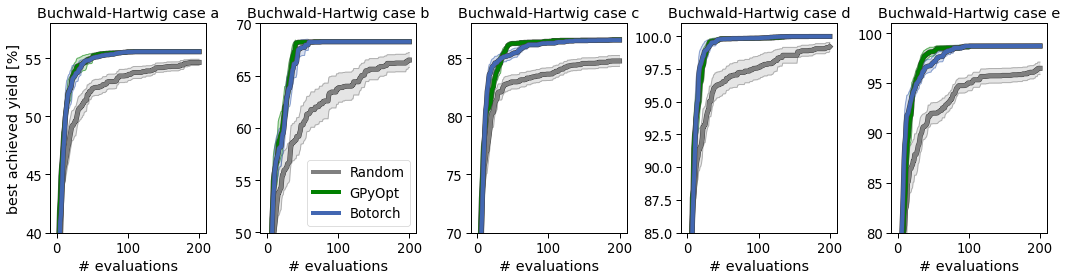

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4), sharex=True)

for i, sub in zip(range(5), ['a', 'b', 'c', 'd', 'e']):
    print(i, sub)
    
    plot_trace_mean(traces_random[sub], obj_num=None, ax=axes[i], color='gray', label='Random')
    plot_trace_mean(traces_gpyopt[sub], obj_num=None, ax=axes[i], color='g', label='GPyOpt')
#    plot_trace_mean(traces_dragonfly[sub], obj_num=None, ax=axes[i], color='#dd882c', label='Dragonfly')
    plot_trace_mean(traces_botorch[sub], obj_num=None, ax=axes[i], color='#4267B2', label='Botorch')
#    plot_trace_mean(traces_gryffin[sub], obj_num=None, ax=axes[i], color='#ffb703', label='Gryffin')
#    plot_trace_mean(traces_hebo[sub], obj_num=None, ax=axes[i], color='#ffb703', label='Hebo')
        
    #axes[i].set_yscale('log')
    #axes[i].set_xscale('log')
    axes[i].set_xlabel('# evaluations')
    
    
    axes[i].set_title(f'Buchwald-Hartwig case {sub}')
    
axes[1].legend(loc='lower right')

axes[0].set_ylim(40, 58)
axes[1].set_ylim(50, 70)
axes[2].set_ylim(70, 88)
axes[3].set_ylim(85, 101)
axes[4].set_ylim(80, 101)

axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()
#plt.savefig('cs2_buchwald_trace_plots.png', dpi=300)

## Case study 3 

comparison of ASF

### plots to make

* traces

## `dye_lasers` example

In [7]:
dataset = 'dye_lasers'
case_study = 'case_study_3'

# load results

data_random = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/RandomSearch/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_random_ = pickle.load(content)
        data_random[sub] = data_random_
        
data_gpyopt = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/Gpyopt/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_gpyopt_ = pickle.load(content)
        data_gpyopt[sub] = data_gpyopt_
    
        
data_botorch = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/Botorch/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_botorch_ = pickle.load(content)
        data_botorch[sub] = data_botorch_
        
        
# data_gryffin = {}
# for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
#     with open(f'{case_study}/Gryffin/{dataset}/{sub}/results.pkl', 'rb') as content:
#         data_gryffin_ = pickle.load(content)
#         data_gryffin[sub] = data_gryffin_
        
        
# data_hebo = {}
# for sub in ['Chimera', 'WeightedSum', 'Parego']:
#     with open(f'{case_study}/Hebo/{sub}/results.pkl', 'rb') as content:
#         data_hebo_ = pickle.load(content)
#         data_hebo[sub] = data_hebo_

In [8]:
scalarizers = {'Chimera' : Scalarizer(
                            kind='Chimera', 
                            value_space=Dataset(kind='dye_lasers').value_space,
                            goals=['max', 'min', 'max'],
                            tolerances=[0.7, 0.2, 0.2],
                            absolutes=[True, True, True]
                        ),
               'WeightedSum':
                   Scalarizer(
                            kind='WeightedSum', 
                            value_space=Dataset(kind='dye_lasers').value_space,
                            goals=['max', 'min', 'max'],
                            weights=[3, 2, 1],
                            
                        ),
                'Parego':
                   Scalarizer(
                            kind='Parego', 
                            value_space=Dataset(kind='dye_lasers').value_space,
                            goals=['max', 'min', 'max'],
                            rho=0.05
                        ),
                'Hypervolume':
                   Scalarizer(
                            kind='Hypervolume', 
                            value_space=Dataset(kind='dye_lasers').value_space,
                            goals=['max', 'min', 'max'],
                        ),
              }


# get traces
traces_random = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_random[sub]= get_traces(data_random[sub], scalarizers[sub])
    
traces_gpyopt = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_gpyopt[sub]= get_traces(data_gpyopt[sub], scalarizers[sub])

traces_botorch = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_botorch[sub]= get_traces(data_botorch[sub], scalarizers[sub])
    
# traces_hebo = {}
# for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
#     traces_hebo[sub]= get_traces(data_hebo[sub], scalarizers[sub])

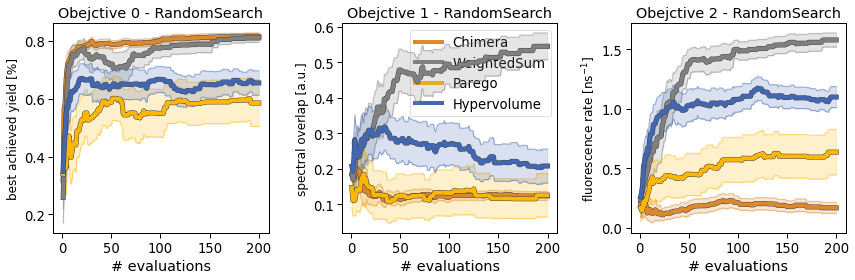

In [9]:
#---------------
# RANDOM SEARCH
#---------------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_random['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_random['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_random['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')
    plot_trace_mean(traces_random['Hypervolume'], obj_num=i, ax=axes[i], color='#4267B2', label='Hypervolume')

        
    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')
    axes[i].set_title(f'Obejctive {i} - RandomSearch')

    
axes[1].legend(loc='upper right')

#axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel('peak score [a.u.]', fontsize=12)
axes[1].set_ylabel('spectral overlap [a.u.]', fontsize=12)
axes[2].set_ylabel('fluorescence rate [ns$^{-1}$]', fontsize=12)


axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()
# plt.savefig('cs2_buchwald_trace_plots.png', dpi=300)

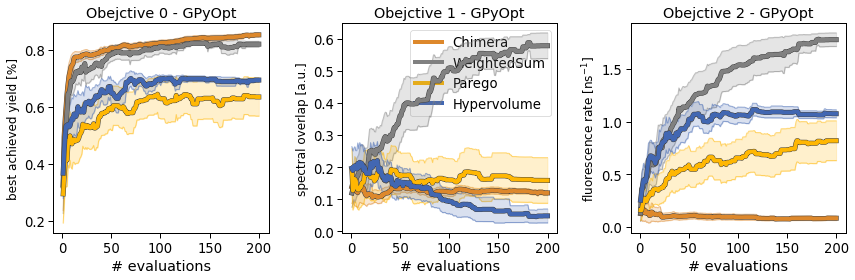

In [10]:
#---------------
# GPYOPT
#---------------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_gpyopt['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_gpyopt['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_gpyopt['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')
    plot_trace_mean(traces_gpyopt['Hypervolume'], obj_num=i, ax=axes[i], color='#4267B2', label='Hypervolume')

        
    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')
    axes[i].set_title(f'Obejctive {i} - GPyOpt')

    
axes[1].legend(loc='upper right')

#axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel('peak score [a.u.]', fontsize=12)
axes[1].set_ylabel('spectral overlap [a.u.]', fontsize=12)
axes[2].set_ylabel('fluorescence rate [ns$^{-1}$]', fontsize=12)


axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()

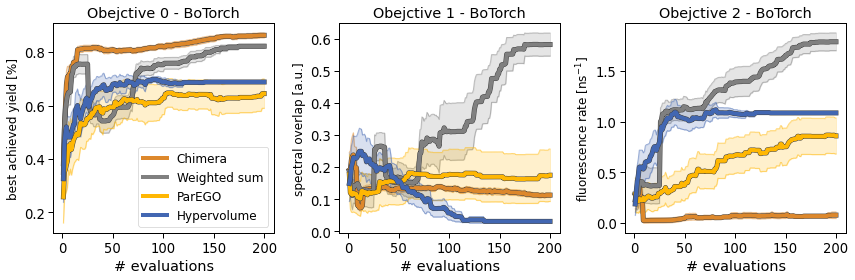

In [11]:
#--------
# BOTORCH 
#--------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_botorch['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_botorch['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='Weighted sum')
    plot_trace_mean(traces_botorch['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='ParEGO')
    plot_trace_mean(traces_botorch['Hypervolume'], obj_num=i, ax=axes[i], color='#4267B2', label='Hypervolume')

    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')
    axes[i].set_title(f'Obejctive {i} - BoTorch')

    
axes[0].legend(loc='lower right', ncol=1, fontsize=12)

#axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel('peak score [a.u.]', fontsize=12)
axes[1].set_ylabel('spectral overlap [a.u.]', fontsize=12)
axes[2].set_ylabel('fluorescence rate [ns$^{-1}$]', fontsize=12)


axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()
plt.savefig('dye_lasers_botorch_traces', dpi=300)

In [12]:
df_orig = Dataset(kind='dye_lasers').data

In [13]:
raw_df = pd.read_csv('../src/olympus/datasets/dataset_dye_lasers/raw_data/20210511_full_props.csv')
# make product mols
prod_smiles = raw_df['smiles'].tolist()
prod_mols = [Chem.MolFromSmiles(s) for s in prod_smiles]

# prod_fps = [np.array(Chem.GetMorganFingerprintAsBitVect(m, 3)) for m in prod_mols ]
prod_fps = [Chem.GetMorganFingerprintAsBitVect(m, 3) for m in prod_mols ]
fps_dict = {s:fp for s, fp in zip(prod_smiles, prod_fps)}
raw_df['product_mols'] = prod_mols
print(raw_df.shape)
raw_df.head()

(3458, 15)


smiles  frag_a_ix  \
0  Fc1cc(-c2cccc(-c3cc(-c4cccc(-c5ccnc(F)c5)c4-n4...          0   
1  Fc1cc(-c2cccc(-c3cc(Cl)c(-c4cccc(-c5ccnc(F)c5)...          0   
2  Cc1nc2c(-c3cccc(-c4ccnc(F)c4)c3-n3c4ccccc4c4cc...          0   
3  Fc1cc(-c2cccc(-c3ccccc3Oc3ccccc3-c3cccc(-c4ccn...          0   
4  CC(C)(C)c1ccc2c(-c3cccc(-c4ccnc(F)c4)c3-n3c4cc...          0   

             frag_a  frag_b_ix  \
0  OB(O)c1ccnc(F)c1          0   
1  OB(O)c1ccnc(F)c1          0   
2  OB(O)c1ccnc(F)c1          0   
3  OB(O)c1ccnc(F)c1          0   
4  OB(O)c1ccnc(F)c1          0   

                                              frag_b  frag_c_ix  \
0  C[N+]12CC(=O)O[B-]1(c1cccc(Br)c1-n1c3ccccc3c3c...          0   
1  C[N+]12CC(=O)O[B-]1(c1cccc(Br)c1-n1c3ccccc3c3c...          1   
2  C[N+]12CC(=O)O[B-]1(c1cccc(Br)c1-n1c3ccccc3c3c...          2   
3  C[N+]12CC(=O)O[B-]1(c1cccc(Br)c1-n1c3ccccc3c3c...          3   
4  C[N+]12CC(=O)O[B-]1(c1cccc(Br)c1-n1c3ccccc3c3c...          4   

                                 frag_c   overlap  fluo_rate_ns  fluo_peak_1  \
0                  Brc1cc(Br)c2ccccc2c1  0.087858      0.001269     0.504702   
1                       Clc1cc(Br)sc1Br  0.061804      0.008200     0.149585   
2         Cc1nc2c(Br)c3nsnc3c(Br)c2nc1C  0.028725      0.000253     0.001274   
3                 Brc1ccccc1Oc1ccccc1Br  0.082928      0.006326     0.737431   
4  CC(C)(C)c1ccc2c(Br)c3ccccc3c(Br)c2c1  0.387919      0.063529     0.419340   

   fluo_peak_2  ext_peak_1  ext_peak_2   route_score  \
0     0.000102    0.004122    0.000298  2.173607e+07   
1     0.002535    0.419553    0.000490  2.167031e+07   
2     0.737458    0.007288    0.036651  2.235180e+07   
3     0.000269    0.030317    0.000328  2.202556e+07   
4     0.000468    0.849190    0.000679  2.247671e+07   

                                       product_mols  
0  <rdkit.Chem.rdchem.Mol object at 0x7ff5863296c0>  
1  <rdkit.Chem.rdchem.Mol object at 0x7ff586329300>  
2  <rdkit.Chem.rdchem.Mol object at 0x7ff586329ee0>  
3  <rdkit.Chem.rdchem.Mol object at 0x7ff586329e40>  
4  <rdkit.Chem.rdchem.Mol object at 0x7ff5863297b0>

In [14]:
def lookup_prod_smiles_mol(frag_a, frag_b, frag_c, raw_df):

    match = raw_df[
        (raw_df['frag_a']==frag_a)&
        (raw_df['frag_b']==frag_b)&
        (raw_df['frag_c']==frag_c)
    ]
    assert len(match)==1
    match = match.to_dict('r')[0]
    smi, mol = match['smiles'], match['product_mols']
    fp = fps_dict[smi]
    return smi, mol, fp

def get_similarity_distribution(campaigns, raw_df):
    
    df_sims = []

    for campaign in campaigns:
        smiles, mols, fps = [], [], []
        for param in campaign.observations.get_params():
            # this is dataset specific
            smi, mol, fp = lookup_prod_smiles_mol(param[0], param[1], param[2], raw_df)
            smiles.append(smi)
            mols.append(mol)
            fps.append(fp)
        # compute all fp pairwise distances without duplicates
        qu, ta, sim = [], [], []

        # compare all fp pairwise without duplicates
        for n in range(len(fps)-1): # -1 so the last fp will not be used
            s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:]) # +1 compare with the next to the last fp
            # collect the SMILES and values
            for m in range(len(s)):
                qu.append(smiles[n])
                ta.append(smiles[n+1:][m])
                sim.append(s[m])

        d = {'query':qu, 'target':ta, 'similarity':sim}
        df_sim = pd.DataFrame(data=d)
        #df_sim = df_sim.sort_values('similarity', ascending=False)
        df_sims.append(df_sim)
    
    return pd.concat(df_sims, ignore_index=True)



def get_similarity_distribution_pareto(campaigns, raw_df):
    
    smiles, mols, fps = [], [], []

    for campaign in campaigns:
        
        params = campaign.observations.get_params()
        values = campaign.observations.get_values()
        values_opp = campaign.observations.get_values(opposite=True)

        pareto_front, pareto_set = get_pareto_set(params, values_opp)
        
        for param in pareto_set:
            # this is dataset specific
            smi, mol, fp = lookup_prod_smiles_mol(param[0], param[1], param[2], raw_df)
            smiles.append(smi)
            mols.append(mol)
            fps.append(fp)
    # compute all fp pairwise distances without duplicates
    qu, ta, sim = [], [], []

    # compare all fp pairwise without duplicates
    for n in range(len(fps)-1): # -1 so the last fp will not be used
        s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:]) # +1 compare with the next to the last fp
        # collect the SMILES and values
        for m in range(len(s)):
            qu.append(smiles[n])
            ta.append(smiles[n+1:][m])
            sim.append(s[m])

    d = {'query':qu, 'target':ta, 'similarity':sim}
    df_sim = pd.DataFrame(data=d)
    #df_sim = df_sim.sort_values('similarity', ascending=False)
    
    return df_sim



In [15]:
df_sim_chimera = get_similarity_distribution(data_botorch['Chimera'], raw_df)
df_sim_weightedsum = get_similarity_distribution(data_botorch['WeightedSum'], raw_df)
df_sim_parego = get_similarity_distribution(data_botorch['Parego'], raw_df)
df_sim_hypervolume = get_similarity_distribution(data_botorch['Hypervolume'], raw_df)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  if __name__ == "__main__":


In [16]:
df_sim_chimera.head()

query  \
0  c1ccc2c(c1)-c1ccccc1C21c2cc(-c3c(-c4ccnc(-n5c6...   
1  c1ccc2c(c1)-c1ccccc1C21c2cc(-c3c(-c4ccnc(-n5c6...   
2  c1ccc2c(c1)-c1ccccc1C21c2cc(-c3c(-c4ccnc(-n5c6...   
3  c1ccc2c(c1)-c1ccccc1C21c2cc(-c3c(-c4ccnc(-n5c6...   
4  c1ccc2c(c1)-c1ccccc1C21c2cc(-c3c(-c4ccnc(-n5c6...   

                                              target  similarity  
0  CCCCC(CC)CC1(CC(CC)CCCC)c2cc(-c3ccccc3-c3ccco3...    0.158730  
1  c1ccc2c(-n3c4ccccc4c4ccccc43)ccc(-c3ccc(-c4cnc...    0.242188  
2  Fc1c(-c2ccc(-c3cccc(-c4ccc(-n5c6ccccc6c6ccccc6...    0.228070  
3  c1ccc(-c2ccccc2-c2cc(-n3c4ccccc4c4ccccc43)cc(-...    0.207207  
4  Fc1cc(-c2cccc(-c3cc(-c4cccc(-c5ccnc(F)c5)c4-n4...    0.245902

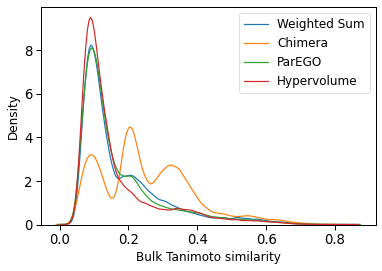

In [17]:
fig, ax = plt.subplots()

sns.kdeplot(df_sim_weightedsum['similarity'], label='Weighted Sum', ax=ax)
sns.kdeplot(df_sim_chimera['similarity'], label='Chimera', ax=ax)
sns.kdeplot(df_sim_parego['similarity'], label='ParEGO', ax=ax)
sns.kdeplot(df_sim_hypervolume['similarity'], label='Hypervolume', ax=ax)

ax.legend(loc='upper right', fontsize=12)
ax.set_xlabel('Bulk Tanimoto similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

plt.savefig('dye_lasers_sim_dist_all.png', dpi=300 )

In [18]:
# similarity of pareto optimial solutions after 200 iterations

df_sim_chimera = get_similarity_distribution_pareto(data_botorch['Chimera'], raw_df)
df_sim_weightedsum = get_similarity_distribution_pareto(data_botorch['WeightedSum'], raw_df)
df_sim_parego = get_similarity_distribution_pareto(data_botorch['Parego'], raw_df)
df_sim_hypervolume = get_similarity_distribution_pareto(data_botorch['Hypervolume'], raw_df)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  if __name__ == "__main__":


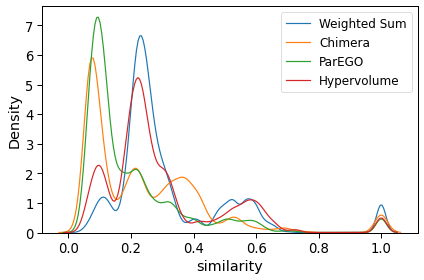

In [19]:
sns.kdeplot(df_sim_weightedsum['similarity'], label='Weighted Sum')
sns.kdeplot(df_sim_chimera['similarity'], label='Chimera')
sns.kdeplot(df_sim_parego['similarity'], label='ParEGO')
sns.kdeplot(df_sim_hypervolume['similarity'], label='Hypervolume')

ax.legend(loc='upper right', fontsize=12)
ax.set_xlabel('Bulk Tanimoto similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig('dye_lasers_sim_dist_pareto.png', dpi=300 )

In [20]:
def get_pareto_data(campaigns):
    
    pareto_fronts, pareto_sets = [], []
    hypervolumes = []
    values_ = []

    # get the pareto optimal sets and the hypervolumes after the 200 evaluation budget
    for campaign in campaigns:

        params = campaign.observations.get_params()
        values = campaign.observations.get_values()
        values_opp = values.copy()
        values_opp[:, 0] *= -1
        values_opp[:, 2] *= -1
        
        pareto_front, pareto_set = get_pareto_set(params, values_opp)
        
        values_full = df_orig[['peak_score', 'spectral_overlap', 'fluo_rate']].values
        values_full[:, 0] *= -1
        values_full[:, 2] *= -1
        
        w_ref = np.amax(values_full, axis=0)
        #print(w_ref)
        hypervolume = get_hypervolume(values_opp, w_ref)
        
        
        pareto_fronts.append(pareto_front)
        pareto_sets.append(pareto_set)
        hypervolumes.append(hypervolume)


        idxs = [ np.where(np.all(values_opp==p, axis=1))[0][0] for p in pareto_front ] 
        assert len(idxs)==pareto_front.shape[0]
        # delete from the original values list --> i.e. not the one with the signs flipped
        values_opp = np.delete(values_opp, idxs, axis=0)
        values_.append(values_opp)
        
    return pareto_fronts, pareto_sets, hypervolumes, values_
    

def make_plotly_df(pareto_fronts, values_):
    front_df = pd.DataFrame(
        {'peak_score': pareto_fronts[:, 0], 'spectral_overlap': pareto_fronts[:, 1], 'fluo_rate': pareto_fronts[:, 2]}
    )
    front_df['type'] = 'front'
    front_df['size'] = 10
    full_df = pd.DataFrame(
        {'peak_score': values_[:, 0], 'spectral_overlap': values_[:, 1], 'fluo_rate': values_[:, 2]}
    )
    full_df['type'] = 'normal'
    full_df['size'] = 2
    df = pd.concat((front_df, full_df))
    return df

In [21]:
pareto_fronts_hv, pareto_sets_hv, hypervolumes_hv, values_hv = get_pareto_data(data_gpyopt['Hypervolume'])
df_hv = make_plotly_df(pareto_fronts_hv[0], values_hv[0])

pareto_fronts_chi, pareto_sets_chi, hypervolumes_chi, values_chi = get_pareto_data(data_gpyopt['Chimera'])
df_chi = make_plotly_df(pareto_fronts_chi[0], values_chi[0])


pareto_fronts_ws, pareto_sets_ws, hypervolumes_ws, values_ws = get_pareto_data(data_gpyopt['WeightedSum'])
df_ws = make_plotly_df(pareto_fronts_ws[0], values_ws[0])

pareto_fronts_par, pareto_sets_par, hypervolumes_par, values_par = get_pareto_data(data_gpyopt['Parego'])
df_par = make_plotly_df(pareto_fronts_par[0], values_par[0])

# full hypervolume
values = df_orig[['peak_score', 'spectral_overlap', 'fluo_rate']].values
values[:, 0] *= -1
values[:, 2] *= -1


w_ref = np.amax(values, axis=0)

#print(w_ref)
full_hypervolume = get_hypervolume(values, w_ref)

In [22]:
df_hvol = pd.concat([
    pd.DataFrame({'hypervol': hypervolumes_hv, 'kind': ['Hypervolume' for _ in range(len(hypervolumes_hv))]}),
    pd.DataFrame({'hypervol': hypervolumes_chi, 'kind': ['Chimera' for _ in range(len(hypervolumes_chi))]}),
    pd.DataFrame({'hypervol': hypervolumes_par, 'kind': ['ParEGO' for _ in range(len(hypervolumes_par))]}),
    pd.DataFrame({'hypervol': hypervolumes_ws, 'kind': ['Weighted Sum' for _ in range(len(hypervolumes_ws))]}),
])

# normalize the hypervolumes
df_hvol['hypervol'] /= full_hypervolume

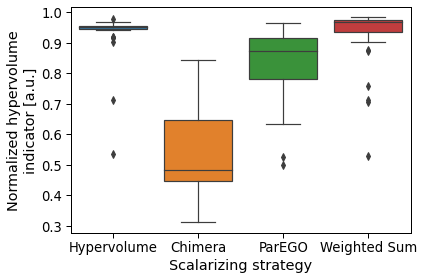

In [23]:
fig, ax = plt.subplots()

sns.boxplot(data=df_hvol, x='kind', y='hypervol', ax=ax)
ax.set_ylabel('Normalized hypervolume\nindicator [a.u.]')
ax.set_xlabel('Scalarizing strategy')

plt.tight_layout()
plt.savefig('dye_lasers_hypervolume_boxplot.png', dpi=300)

In [24]:
fig = px.scatter_3d(df_chi, x='peak_score', y='spectral_overlap', z='fluo_rate', size='size')
pareto_points = df_chi[df_chi['type']=='front']
fig.add_trace(go.Mesh3d(x=pareto_points['peak_score'].values,
                   y=pareto_points['spectral_overlap'].values,
                   z=pareto_points['fluo_rate'].values,
                   opacity=0.2,
                   color='blue'
                  ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [25]:
fig = px.scatter_3d(df_hv, x='peak_score', y='spectral_overlap', z='fluo_rate', size='size')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [26]:
fig = px.scatter_3d(df_ws, x='peak_score', y='spectral_overlap', z='fluo_rate', size='size')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [27]:
fig = px.scatter_3d(df_par, x='peak_score', y='spectral_overlap', z='fluo_rate', size='size')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

## `redoxmers` example

In [5]:
dataset = 'redoxmers'
case_study = 'case_study_3'

# load results

data_random = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/RandomSearch/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_random_ = pickle.load(content)
        data_random[sub] = data_random_
        
data_gpyopt = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/Gpyopt/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_gpyopt_ = pickle.load(content)
        data_gpyopt[sub] = data_gpyopt_
    
        
data_botorch = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/Botorch/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_botorch_ = pickle.load(content)
        data_botorch[sub] = data_botorch_
        
        
data_gryffin = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/Gryffin/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_gryffin_ = pickle.load(content)
        data_gryffin[sub] = data_gryffin_
        
        
# data_hebo = {}
# for sub in ['Chimera', 'WeightedSum', 'Parego']:
#     with open(f'{case_study}/Hebo/{sub}/results.pkl', 'rb') as content:
#         data_hebo_ = pickle.load(content)
#         data_hebo[sub] = data_hebo_

data_gryffin['Chimera']

[<Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>]

In [6]:
scalarizers = {'Chimera' : Scalarizer(
                            kind='Chimera', 
                            value_space=Dataset(kind='redoxmers').value_space,
                            goals=['min', 'min', 'min'],
                            tolerances=[25., 2.04, 0.0],
                            absolutes=[True, True, False]
                        ),
               'WeightedSum':
                    Scalarizer(
                        kind='WeightedSum', 
                        value_space=Dataset(kind='redoxmers').value_space,
                        goals=['min', 'min', 'min'],
                        weights=[3., 2., 1.],
                    ),
                'Parego':
                   Scalarizer(
                        kind='Parego', 
                        value_space=Dataset(kind='redoxmers').value_space,
                        goals=['min', 'min', 'min'],
                        rho=0.05,
                    ),
                'Hypervolume':
                    Scalarizer(
                        kind='Hypervolume',
                        value_space=Dataset(kind='redoxmers').value_space,
                        goals=['min', 'min', 'min'],
                    )
              }


# get traces
traces_random = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_random[sub]= get_traces(data_random[sub], scalarizers[sub])
    
traces_gpyopt = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_gpyopt[sub]= get_traces(data_gpyopt[sub], scalarizers[sub])

traces_botorch = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_botorch[sub]= get_traces(data_botorch[sub], scalarizers[sub])
    
traces_gryffin = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_gryffin[sub] = get_traces(data_gryffin[sub], scalarizers[sub])
    
# traces_hebo = {}
# for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
#     traces_hebo[sub]= get_traces(data_hebo[sub], scalarizers[sub])

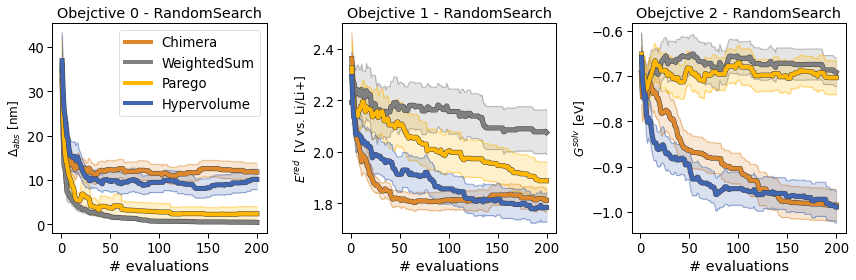

In [7]:
#---------------
# RANDOM SEARCH
#---------------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_random['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_random['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_random['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')
    plot_trace_mean(traces_random['Hypervolume'], obj_num=i, ax=axes[i], color='#4267B2', label='Hypervolume')

        
    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')
    axes[i].set_title(f'Obejctive {i} - RandomSearch')

    
axes[0].legend(loc='upper right')

#axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel(r'$\Delta_{abs}$ [nm]', fontsize=12)
axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)


#axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()
# plt.savefig('cs2_buchwald_trace_plots.png', dpi=300)

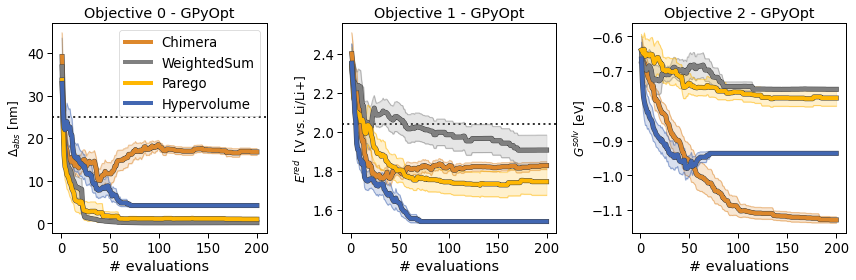

In [8]:
#---------------
# GPYOPT
#---------------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_gpyopt['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_gpyopt['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_gpyopt['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')
    plot_trace_mean(traces_gpyopt['Hypervolume'], obj_num=i, ax=axes[i], color='#4267B2', label='Hypervolume')

        
    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')
    axes[i].set_title(f'Objective {i} - GPyOpt')

    
axes[0].legend(loc='upper right')

#axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel(r'$\Delta_{abs}$ [nm]', fontsize=12)
axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)

axes[0].axhline(25., c='k', lw=2, ls=':', alpha=0.8)
axes[1].axhline(2.04, c='k', lw=2, ls=':', alpha=0.8)

#axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()
# plt.savefig('cs2_buchwald_trace_plots.png', dpi=300)

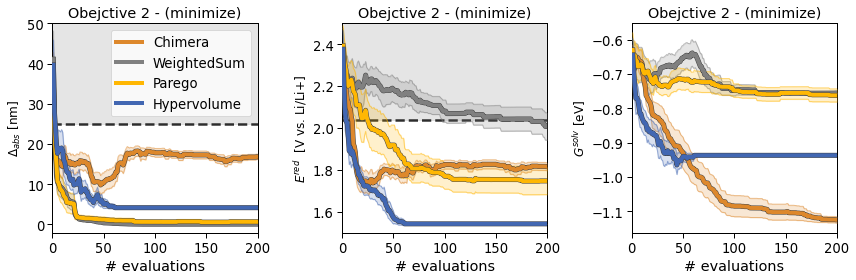

In [24]:
#---------------
# BOTORCH
#---------------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_botorch['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_botorch['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_botorch['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')
    plot_trace_mean(traces_botorch['Hypervolume'], obj_num=i, ax=axes[i], color='#4267B2', label='Hypervolume')

        
    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')

axes[0].set_title(f'Obejctive {i} - (minimize)')
axes[1].set_title(f'Obejctive {i} - (minimize)')
axes[2].set_title(f'Obejctive {i} - (minimize)')    

axes[0].legend(loc='upper right')

#axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel(r'$\Delta_{abs}$ [nm]', fontsize=12)
axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)

axes[0].axhline(25., ls='--',  c='k', lw=2.5, alpha=0.8)
axes[0].fill_between(x=[0,200], y1=25., y2=50, alpha=0.2, color='gray')
axes[0].set_xlim(0, 200)
axes[0].set_ylim(-2, 50)


axes[1].axhline(2.04, ls='--',  c='k', lw=2.5, alpha=0.8)
axes[1].fill_between(x=[0,200], y1=2.04, y2=2.5, alpha=0.2, color='gray')
axes[1].set_xlim(0, 200)
axes[1].set_ylim(1.5, 2.5)


#axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()
plt.savefig('redoxmers_botorch_traces.png', dpi=300)

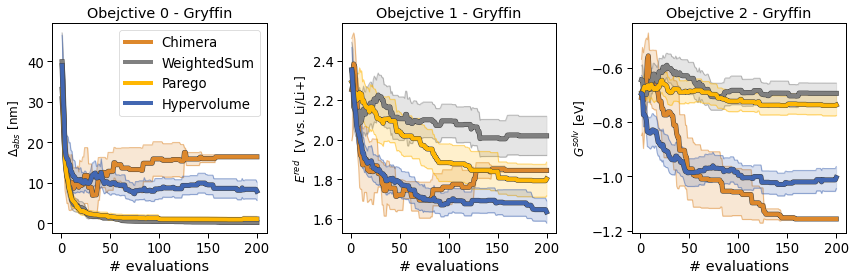

In [11]:
#---------------
# GRYFFIN
#---------------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_gryffin['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_gryffin['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_gryffin['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')
    plot_trace_mean(traces_gryffin['Hypervolume'], obj_num=i, ax=axes[i], color='#4267B2', label='Hypervolume')

        
    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')
    axes[i].set_title(f'Obejctive {i} - Gryffin')

    
axes[0].legend(loc='upper right')

#axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel(r'$\Delta_{abs}$ [nm]', fontsize=12)
axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)


#axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()
# plt.savefig('cs2_buchwald_trace_plots.png', dpi=300)

In [28]:
df_orig = Dataset(kind='redoxmers').data

In [29]:
df_orig.head()

r1_label r3_label r4_label r5_label abs_lam_diff      ered      gsol
0     R1_0     R3_0     R4_0     R5_0        39.96  1.684123 -0.681801
1     R1_0     R3_0     R4_0     R5_1        63.92  1.963624 -0.711542
2     R1_0     R3_0     R4_0     R5_2        51.76  2.044655   -0.8874
3     R1_0     R3_0     R4_0     R5_3        36.93  1.731604 -0.710235
4     R1_0     R3_0     R4_0     R5_4        53.79  1.844226 -0.748112

In [30]:
raw_df = pd.read_csv('../src/olympus/datasets/dataset_redoxmers/raw_data/df_results.csv')
# make product mols
prod_smiles = raw_df['product_smiles'].tolist()
prod_mols = [Chem.MolFromSmiles(s) for s in prod_smiles]

# prod_fps = [np.array(Chem.GetMorganFingerprintAsBitVect(m, 3)) for m in prod_mols ]
prod_fps = [Chem.GetMorganFingerprintAsBitVect(m, 3) for m in prod_mols ]
fps_dict = {s:fp for s, fp in zip(prod_smiles, prod_fps)}
raw_df['product_mols'] = prod_mols
print(raw_df.shape)
raw_df.head()

(1407, 2395)


Unnamed: 0                               product_smiles r1_label r1_smiles  \
0           0          CCOCN(C(C)=O)c1c(C)c(C)c(C)c2nsnc12     R1_0      CCOC   
1           1   CCOCN(C(C)=O)c1c(C)c(C)c(C(F)(F)F)c2nsnc12     R1_0      CCOC   
2           2        CCOCN(C(C)=O)c1c(C)c(C)c(C#N)c2nsnc12     R1_0      CCOC   
3           3         CCOCN(C(C)=O)c1c(C)c(C)c(OC)c2nsnc12     R1_0      CCOC   
4           4  CCOCN(C(C)=O)c1c(C)c(C)c(OC(F)(F)F)c2nsnc12     R1_0      CCOC   

  r1_smiles_raw r3_label r3_smiles r3_smiles_raw r4_label r4_smiles  ...  \
0          CCOC     R3_0         C             C     R4_0         C  ...   
1          CCOC     R3_0         C             C     R4_0         C  ...   
2          CCOC     R3_0         C             C     R4_0         C  ...   
3          CCOC     R3_0         C             C     R4_0         C  ...   
4          CCOC     R3_0         C             C     R4_0         C  ...   

       r5_MW     r5_AMW r5_WPath r5_WPol  r5_Zagreb1  r5_Zagreb2  r5_mZagreb2  \
0  16.031300   3.206260        0       0         0.0         0.0          0.0   
1  70.003035  14.000607        9       0        12.0         9.0          1.0   
2  27.010899   9.003633        1       0         2.0         1.0          1.0   
3  32.026215   5.337702        1       0         2.0         1.0          1.0   
4  85.997949  14.332992       16       0        20.0        16.0          1.0   

   r5_type  r5_ix                                      product_mols  
0       R5      0  <rdkit.Chem.rdchem.Mol object at 0x7fe1ba576800>  
1       R5      1  <rdkit.Chem.rdchem.Mol object at 0x7fe1b93fb670>  
2       R5      2  <rdkit.Chem.rdchem.Mol object at 0x7fe1ba5ac670>  
3       R5      3  <rdkit.Chem.rdchem.Mol object at 0x7fe1ba57f9e0>  
4       R5      4  <rdkit.Chem.rdchem.Mol object at 0x7fe1ba57f670>  

[5 rows x 2395 columns]

In [31]:
def lookup_prod_smiles_mol(r1_label, r3_label, r4_label, r5_label, raw_df):
    
    match = raw_df[
        (raw_df['r1_label']==r1_label)&
        (raw_df['r3_label']==r3_label)&
        (raw_df['r4_label']==r4_label)&
        (raw_df['r5_label']==r5_label)
    ]
    assert len(match)==1
    match = match.to_dict('r')[0]
    smi, mol = match['product_smiles'], match['product_mols']
    fp = fps_dict[smi]
    return smi, mol, fp

def get_similarity_distribution(campaigns, raw_df):
    
    smiles, mols, fps = [], [], []

    for campaign in campaigns:
        for param in campaign.observations.get_params():
            # this is dataset specific
            smi, mol, fp = lookup_prod_smiles_mol(param[0], param[1], param[2], param[3], raw_df)
            smiles.append(smi)
            mols.append(mol)
            fps.append(fp)
    # compute all fp pairwise distances without duplicates
    qu, ta, sim = [], [], []

    # compare all fp pairwise without duplicates
    for n in range(len(fps)-1): # -1 so the last fp will not be used
        s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:]) # +1 compare with the next to the last fp
        # collect the SMILES and values
        for m in range(len(s)):
            qu.append(smiles[n])
            ta.append(smiles[n+1:][m])
            sim.append(s[m])

    d = {'query':qu, 'target':ta, 'similarity':sim}
    df_sim = pd.DataFrame(data=d)
    #df_sim = df_sim.sort_values('similarity', ascending=False)
    
    return df_sim


In [32]:
df_sim_chimera = get_similarity_distribution(data_gpyopt['Chimera'][:1], raw_df)
df_sim_weightedsum = get_similarity_distribution(data_gpyopt['WeightedSum'][:1], raw_df)
df_sim_parego = get_similarity_distribution(data_gpyopt['Parego'][:1], raw_df)
df_sim_hypervolume = get_similarity_distribution(data_gpyopt['Hypervolume'][:1], raw_df)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


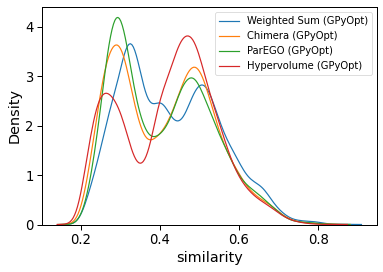

In [33]:
sns.kdeplot(df_sim_weightedsum['similarity'], label='Weighted Sum (GPyOpt)')
sns.kdeplot(df_sim_chimera['similarity'], label='Chimera (GPyOpt)')
sns.kdeplot(df_sim_parego['similarity'], label='ParEGO (GPyOpt)')
sns.kdeplot(df_sim_hypervolume['similarity'], label='Hypervolume (GPyOpt)')

plt.legend(loc='upper right', fontsize=10)


In [34]:
def get_pareto_data(campaigns):
    
    pareto_fronts, pareto_sets = [], []
    hypervolumes = []
    values_ = []

    # get the pareto optimal sets and the hypervolumes after the 200 evaluation budget
    for campaign in campaigns:

        params = campaign.observations.get_params()
        values = campaign.observations.get_values()

        pareto_front, pareto_set = get_pareto_set(params, values)
        w_ref = np.amax(df_orig[['abs_lam_diff', 'ered', 'gsol']].values, axis=0)
        #print(w_ref)
        hypervolume = get_hypervolume(values, w_ref)
        

        pareto_fronts.append(pareto_front)
        pareto_sets.append(pareto_set)
        hypervolumes.append(hypervolume)


        idxs = [ np.where(np.all(values==p, axis=1))[0][0] for p in pareto_front ] 
        assert len(idxs)==pareto_front.shape[0]
        values = np.delete(values, idxs, axis=0)
        values_.append(values)
        
    return pareto_fronts, pareto_sets, hypervolumes, values_
    

def make_plotly_df(pareto_fronts, values_):
    front_df = pd.DataFrame(
        {'abs_lam_diff': pareto_fronts[:, 0], 'ered': pareto_fronts[:, 1], 'gsol': pareto_fronts[:, 2]}
    )
    front_df['type'] = 'front'
    front_df['size'] = 10
    full_df = pd.DataFrame(
        {'abs_lam_diff': values_[:, 0], 'ered': values_[:, 1], 'gsol': values_[:, 2]}
    )
    full_df['type'] = 'normal'
    full_df['size'] = 2
    df = pd.concat((front_df, full_df))
    return df


In [35]:
pareto_fronts_hv, pareto_sets_hv, hypervolumes_hv, values_hv = get_pareto_data(data_gpyopt['Hypervolume'])
df_hv = make_plotly_df(pareto_fronts_hv[0], values_hv[0])

pareto_fronts_chi, pareto_sets_chi, hypervolumes_chi, values_chi = get_pareto_data(data_gpyopt['Chimera'])
df_chi = make_plotly_df(pareto_fronts_chi[0], values_chi[0])


pareto_fronts_ws, pareto_sets_ws, hypervolumes_ws, values_ws = get_pareto_data(data_gpyopt['WeightedSum'])
df_ws = make_plotly_df(pareto_fronts_ws[0], values_ws[0])

pareto_fronts_par, pareto_sets_par, hypervolumes_par, values_par = get_pareto_data(data_gpyopt['Parego'])
df_par = make_plotly_df(pareto_fronts_par[0], values_par[0])

# full hypervolume
values = df_orig[['abs_lam_diff', 'ered', 'gsol']].values
w_ref = np.amax(values, axis=0)
#print(w_ref)
full_hypervolume = get_hypervolume(values, w_ref)


In [36]:
df_hvol = pd.concat([
    pd.DataFrame({'hypervol': hypervolumes_hv, 'kind': ['Hypervolume' for _ in range(len(hypervolumes_hv))]}),
    pd.DataFrame({'hypervol': hypervolumes_chi, 'kind': ['Chimera' for _ in range(len(hypervolumes_chi))]}),
    pd.DataFrame({'hypervol': hypervolumes_par, 'kind': ['ParEGO' for _ in range(len(hypervolumes_par))]}),
    pd.DataFrame({'hypervol': hypervolumes_ws, 'kind': ['Weighted Sum' for _ in range(len(hypervolumes_ws))]}),
])

# normalize the hypervolumes
df_hvol['hypervol'] /= full_hypervolume

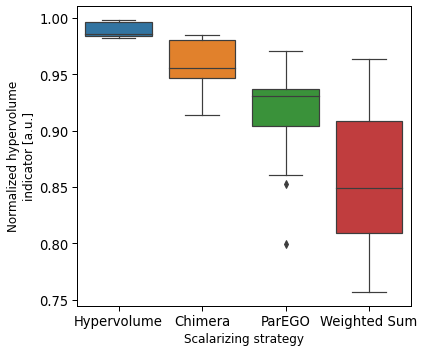

In [37]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.boxplot(data=df_hvol, x='kind', y='hypervol', ax=ax)
ax.set_ylabel('Normalized hypervolume\nindicator [a.u.]', fontsize=12)
ax.set_xlabel('Scalarizing strategy', fontsize=12)

plt.tight_layout()
plt.savefig('redoxmers_hypervolume_boxplots.png', dpi=300)

In [38]:
fig = px.scatter_3d(df_hv, x='abs_lam_diff', y='ered', z='gsol', size='size')
pareto_points = df_hv[df_hv['type']=='front']
fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [25]:
fig = px.scatter_3d(df_chi, x='abs_lam_diff', y='ered', z='gsol', size='size')
pareto_points = df_chi[df_chi['type']=='front']
fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [101]:
fig = px.scatter_3d(df_ws, x='abs_lam_diff', y='ered', z='gsol', size='size')

pareto_points = df_ws[df_ws['type']=='front']

fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))


In [103]:
fig = px.scatter_3d(df_par, x='abs_lam_diff', y='ered', z='gsol', size='size')
pareto_points = df_par[df_par['type']=='front']

fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [39]:
dataset = Dataset(kind='redoxmers')

planner = Botorch()
planner.set_param_space(dataset.param_space)

campaign = Campaign()
campaign.set_param_space(dataset.param_space)
campaign.set_value_space(dataset.value_space)

scalarizer = Scalarizer(
                kind='Chimera', 
                value_space=dataset.value_space,
                goals=['min', 'min', 'min'],
                tolerances=[25., 2.04, 0.0],
                absolutes=[True, True, False]
            )

evaluator = Evaluator(
                planner=planner, 
                emulator=dataset,
                campaign=campaign,
                scalarizer=scalarizer,
            )


evaluator.optimize(num_iter=200)


NameError: name 'Botorch' is not defined